In [1]:
%matplotlib inline
import numpy as np
import healpy as hp
import matplotlib.pylab as plt
import lsst.sims.featureScheduler as fs
from lsst.sims.utils import _hpid2RaDec
from scipy.optimize import minimize, basinhopping

In [2]:
nside = 128
current_obs = np.random.rand(hp.nside2npix(nside))
ra, dec = _hpid2RaDec(nside, np.arange(hp.nside2npix(nside)))
out =  np.where( (ra < np.radians(45)) | (ra > np.radians(55.)))
current_obs[out] = hp.UNSEEN
current_obs[np.where(np.abs(dec) > np.radians(7.))] = hp.UNSEEN

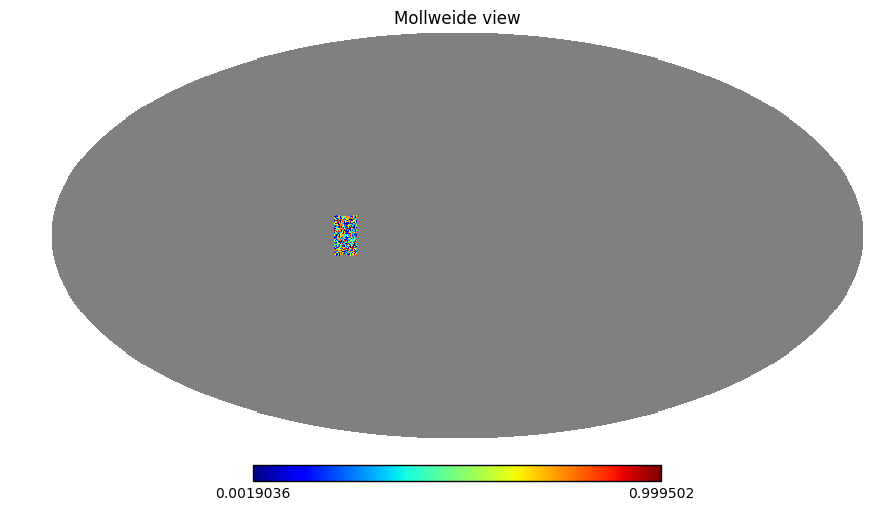

In [3]:
hp.mollview(current_obs)

In [4]:
hpc = fs.hpmap_cross(nside=nside)

In [5]:
hpc.set_map(current_obs)
print hpc([np.radians(50), np.radians(0.), 0.])
print hpc([np.radians(50), np.radians(0.), np.radians(30.)])

292.389544188
304.705276047


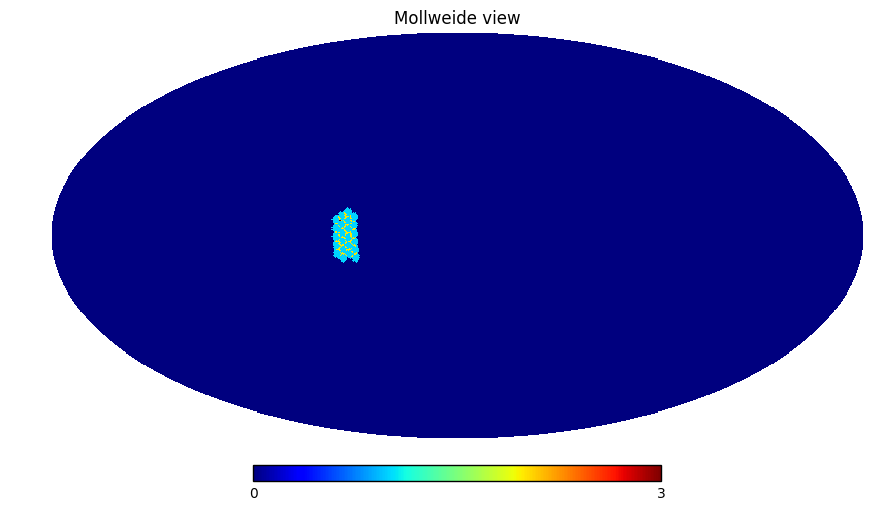

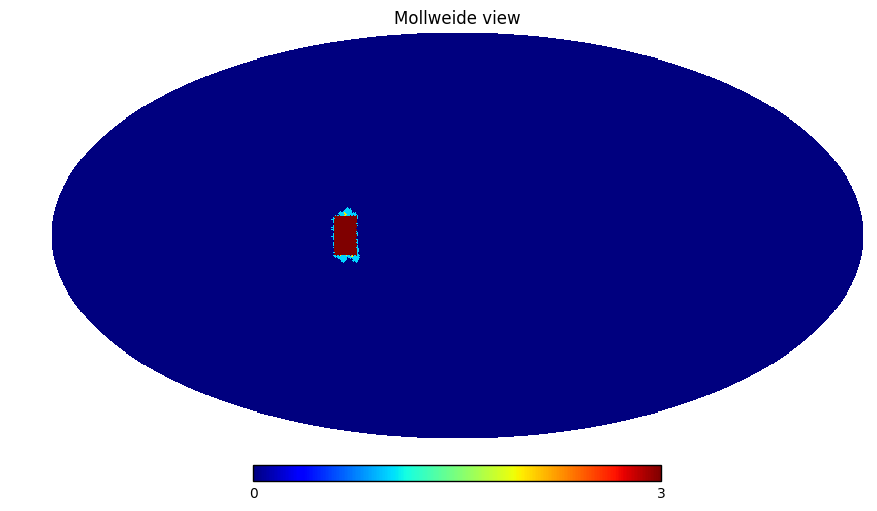

In [6]:
ra_point, dec_point, obs_map = hpc([np.radians(50), np.radians(0.), np.radians(30.)], return_pointings_map=True)
hp.mollview(obs_map)
good = np.where(current_obs != hp.UNSEEN)
obs_map[good] = 3
hp.mollview(obs_map)

In [7]:
ra_point.size

23

In [8]:
ra_mid = np.radians(50.)
dec_mid = 0.
ra_delta = np.radians(1.75)
dec_delta = np.radians(1.75)
bounds = [[ra_mid-ra_delta, ra_mid+ra_delta], [dec_mid-dec_delta, dec_mid+dec_delta], [-np.pi, np.pi]]
best_fit = minimize(hpc, [np.radians(50), np.radians(1.), np.radians(30.)], bounds=bounds, method='SLSQP')

In [9]:
best_fit

     fun: 294.96168554494716
     jac: array([ 0.,  0.,  0.])
 message: 'Optimization terminated successfully.'
    nfev: 5
     nit: 1
    njev: 1
  status: 0
 success: True
       x: array([ 0.87266463,  0.01745329,  0.52359878])

In [10]:
np.degrees(best_fit.x)

array([ 50.,   1.,  30.])

In [11]:
print hpc([np.radians(50), np.radians(0.), np.radians(30.)])
print hpc([np.radians(50), np.radians(0.+.001), np.radians(30.+.01)])

304.705276047
304.02924624


In [12]:
hpc([np.radians(50), np.radians(0.), np.radians(30.)]) == hpc([np.radians(50), np.radians(0.+.001), np.radians(30.+.01)])

False

In [13]:
best_fit = basinhopping(hpc, [np.radians(50), np.radians(1.), np.radians(30.)], stepsize=np.radians(1.75))

In [14]:
best_fit

                        fun: 291.33984563595715
 lowest_optimization_result:       fun: 291.33984563595715
 hess_inv: array([[1, 0, 0],
       [0, 1, 0],
       [0, 0, 1]])
      jac: array([ 0.,  0.,  0.])
  message: 'Optimization terminated successfully.'
     nfev: 5
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([ 0.85450244, -0.02893319,  0.52008483])
                    message: ['requested number of basinhopping iterations completed successfully']
      minimization_failures: 0
                       nfev: 505
                        nit: 100
                       njev: 101
                          x: array([ 0.85450244, -0.02893319,  0.52008483])

In [15]:
np.degrees(best_fit.x)

array([ 48.95938346,  -1.65774982,  29.79866561])

In [16]:
delta = np.radians(30.)
init_rots_grid = np.arange(-np.pi, np.pi+delta, delta)
delta = np.radians(0.5)
dec_grid = np.arange(np.radians(-1.75), np.radians(1.75)+delta, delta)
ra_grid = dec_grid + np.radians(50.)
results = np.zeros((dec_grid.size, ra_grid.size), dtype=float)

In [17]:
results.shape, results.size

((8, 8), 64)

In [18]:
#for i,init_rot in enumerate(init_rots_grid):
for j, dec in enumerate(dec_grid):
    for k, ra in enumerate(ra_grid):
        results[j,k] = hpc([ra, dec, 0.])

In [20]:
#[ra, dec, init_rot]

In [21]:
np.where(results == results.min())

(array([4]), array([4]))

In [22]:
np.degrees([init_rots_grid[6], dec_grid[1], ra_grid[4]])

array([ -5.08888749e-14,  -1.25000000e+00,   5.02500000e+01])

In [23]:
results.min()

292.57486300630848

In [72]:
# Let's see if I can specify the starting simplex
# Need 4 points to start with
x0 = np.array([np.radians(50), np.radians(0.), np.radians(-30.)])
init_simplex = np.zeros((x0.size+1, x0.size), dtype=float)
delta = .5
init_simplex[0] = x0
init_simplex[1] = np.array([np.radians(50), np.radians(0.+delta), np.radians(30)])
init_simplex[2] = np.array([np.radians(50-delta), np.radians(0.), np.radians(-30.)])
init_simplex[3] = np.array([np.radians(50+delta), np.radians(0.+delta), np.radians(90.)])


best_fit = minimize(hpc, x0, method='Nelder-Mead', options={'initial_simplex': init_simplex})

In [73]:
best_fit

 final_simplex: (array([[ 0.8598019 , -0.00787846, -2.33759018],
       [ 0.85980136, -0.00787866, -2.33761347],
       [ 0.85980163, -0.00787866, -2.33759476],
       [ 0.85980122, -0.00787886, -2.33764885]]), array([ 291.85459283,  291.85459283,  291.85459283,  291.85459283]))
           fun: 291.85459282507611
       message: 'Optimization terminated successfully.'
          nfev: 94
           nit: 32
        status: 0
       success: True
             x: array([ 0.8598019 , -0.00787846, -2.33759018])

In [74]:
np.degrees(best_fit.final_simplex[0])

array([[  49.26302024,   -0.4514023 , -133.93405174],
       [  49.26298903,   -0.45141382, -133.93538579],
       [  49.26300471,   -0.45141407, -133.93431393],
       [  49.26298105,   -0.45142541, -133.93741324]])

In [75]:
print np.degrees(best_fit.x)
print best_fit.fun

[  49.26302024   -0.4514023  -133.93405174]
291.854592825


In [ ]:
#291.53376769